# LSUN 64x64 Model Training Notebook


## In this notebook, I create and train a variety of models using the LSUN dataset at 64x64. This notebook contains a sample of the experiments run as part of the project but is not exhaustive.

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import PIL
from IPython import display
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.config.experimental.list_physical_devices('GPU')

gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Set Mirrored Strategy For Distributed Processing

In [3]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Image Prep Function
## Crop and resize images, cast to tanh range

In [4]:
@tf.function
def prepare_image(img, dim=64): 
    img = img['image']
    img = tf.image.random_flip_left_right(img)
    img = tf.image.central_crop(img, 0.75)
    img = tf.image.resize(img,size=[dim,dim])#,method='lanczos3')
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return img

In [5]:
#Import DCGAN class
from SourceFiles.ModelSourceFiles.DCGAN import *

#Import Utilities
from SourceFiles.Utilities.Utils import *

In [6]:
lsun_bedroom = tfds.load('lsun/bedroom')

In [7]:
lsun_bedroom = lsun_bedroom['train']

# Create LSUN Dataset

In [8]:
### LSUN datast ##
BUFFER_SIZE = 60000
BATCH_SIZE = 128 * strategy.num_replicas_in_sync  #batch size * num of gpus
lsun_bedroom = lsun_bedroom.map(prepare_image)
lsun_bedroom = lsun_bedroom.shuffle(BUFFER_SIZE)
lsun_bedroom = lsun_bedroom.batch(BATCH_SIZE)
lsun_bedroom = lsun_bedroom.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
lsun_bedroom

<PrefetchDataset shapes: (None, 64, 64, 3), types: tf.float32>

# Check Image

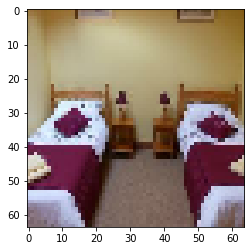

In [10]:
img = lsun_bedroom.take(1)
for each in img:
    each = each.numpy()
    plt.imshow((each[1, :, :, :] * 127.5 + 127.5).astype(np.uint8))
plt.show()

# Train A DCGAN Model

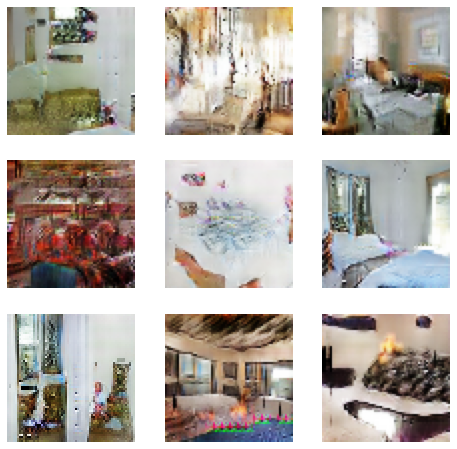

11848/11848 [==============================] - 8041s 679ms/step - Average_Discriminator_Loss: 0.2738 - Generator_Loss: 1.4730 - Discriminator_Real_Loss: 0.2681 - Discriminator_Generator_Loss: 0.2795
CPU times: user 5h 6min 3s, sys: 41min 13s, total: 5h 47min 17s
Wall time: 8h 57min 59s


In [16]:
%%time
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
    gen_dict = {'num_latent':128,
             "filter_num":[768,512,384,256],
             "filter_size":[8,5,5,5], 
             "strides":[2,2,2,2],
             'dense':(4,4,1024), 
             'activation':'relu', 
             'out_channels':3,
             'latent_distribution':'normal'}
    
    disc_dict = {"filter_num": [128, 256, 512],
             "filter_size": [5, 5, 5],
             'activation': 'leakyrelu',
             'out_channels': 3,
             'dropout':0,
             'noise':False}

    model = DCGAN(gen_dict=gen_dict, disc_dict=disc_dict, batch_size=128, model_name='LSUN_64_128_Uniform_15_Rerun', distribute=True)
    model.compile(generator_optimizer, discriminator_optimizer, 
                  tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     #label_smoothing=0.1,
                                                     reduction =tf.keras.losses.Reduction.NONE))
    save_callback = SaveModelAndCreateImages()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model.log_path)
    model.fit(x=lsun_bedroom, epochs=4, callbacks=[save_callback,tensorboard_callback],shuffle=True)
    
        

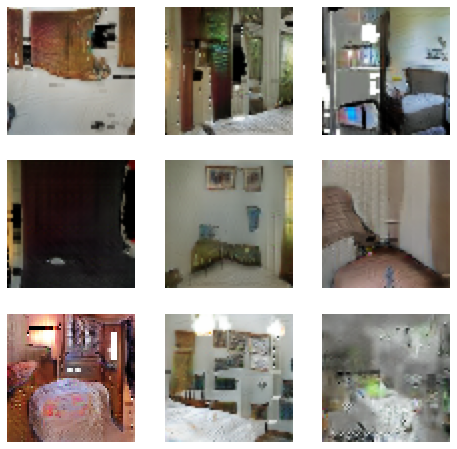

11848/11848 [==============================] - 8030s 678ms/step - Average_Discriminator_Loss: 0.2329 - Generator_Loss: 1.2270 - Discriminator_Real_Loss: 0.2417 - Discriminator_Generator_Loss: 0.2242
Epoch 4/5


KeyboardInterrupt: 

In [17]:
with strategy.scope():
    model.fit(x=lsun_bedroom, epochs=5, callbacks=[save_callback,tensorboard_callback],shuffle=True)

%load_ext tensorboard
%tensorboard --logdir=LSUN_64_128_Uniform_15_Rerun/logs

In [18]:
Generator = model.gen_model

# Use Generator To Generate Images Of Bedrooms

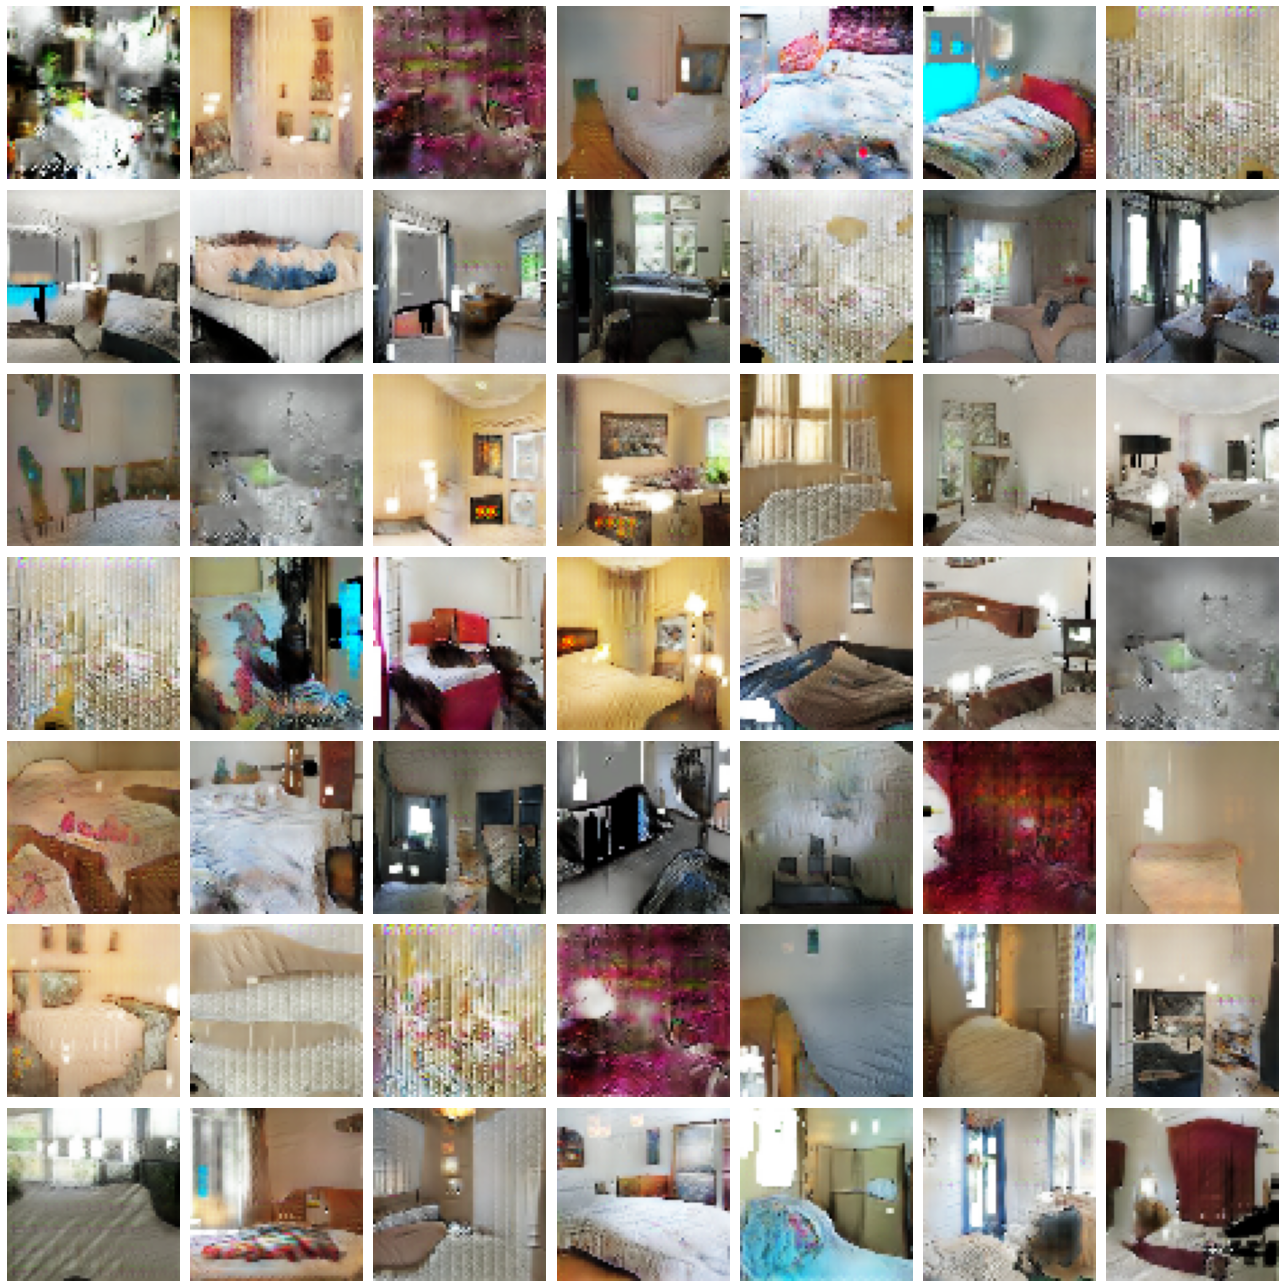

In [26]:
rand = tf.random.normal([49, 128],stddev=0.2)
predictions = Generator(rand)
predictions = predictions.numpy()
fig = plt.figure(figsize=(18, 18))

for i in range(predictions.shape[0]):
    plt.subplot(7, 7, i + 1)
    plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5).astype(np.uint8))
    plt.axis('off')
fig.tight_layout()
fig.savefig('LSUN_Random_Norm_64x64_9_epoch')